In [ ]:
# STEP 1: Install the libraries (if not existing already) [already installed for me]

# !pip install yfinance pandas numpy matplotlib scikit-learn

In [ ]:
# STEP 2: Importing the libraries

import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import pytz
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
plt.style.use('seaborn-v0_8-darkgrid')

In [3]:
# STEP 3: Fetch stock data

# We can choose any company that we want the data for.
# The ticker should be accurate.
# Can be found from "https://ca.finance.yahoo.com"
ticker = 'TSLA'   # Tesla

# Download historical data (daily prices)
# Took data from Jan 2020 to Oct 2025
data = yf.download(ticker, start='2025-01-01', end='2025-10-01')

# Show first few rows for verification
print("Dataset shape:", data.shape)
data.head()

/tmp/ipython-input-37984150.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2025-01-01', end='2025-10-01')
[*********************100%***********************]  1 of 1 completed

Dataset shape: (186, 5)


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2025-01-02,379.279999,392.730011,373.040009,390.100006,109710700
2025-01-03,410.440002,411.880005,379.450012,381.480011,95423300
2025-01-06,411.049988,426.429993,401.700012,423.200012,85516500
2025-01-07,394.359985,414.329987,390.000000,405.829987,75699500
2025-01-08,394.940002,402.500000,387.399994,392.950012,73038800


Missing values in dataset:
 Price   Ticker
Close   TSLA      0
High    TSLA      0
Low     TSLA      0
Open    TSLA      0
Volume  TSLA      0
dtype: int64


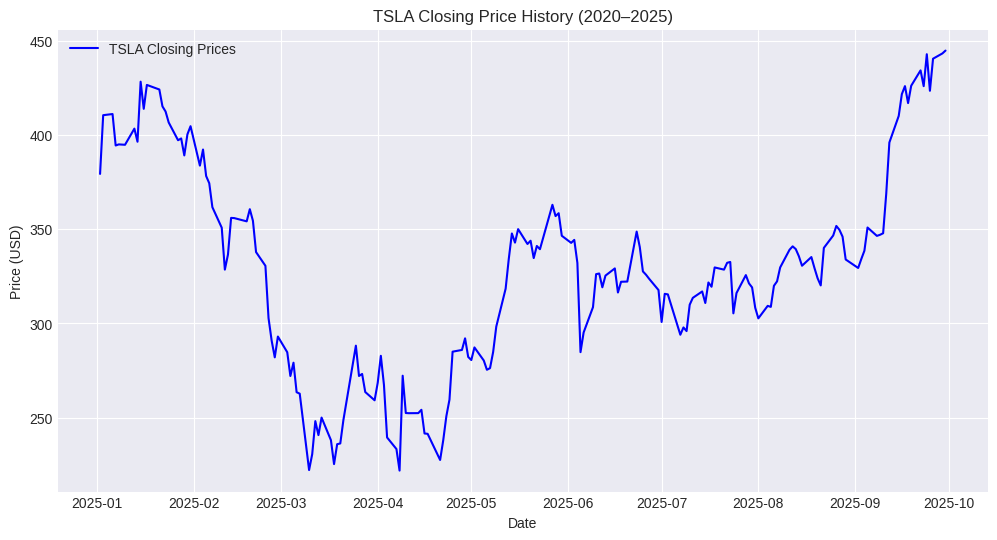

In [4]:
# STEP 4: Data Cleaning and Visualization
# (Lecture 3: Data preprocessing before training)

# Check for missing values
print("Missing values in dataset:\n", data.isnull().sum())

# Delete any rows with missing data
data.dropna(inplace=True)

# Keep only the 'Close' price column for prediction (Lecture 8: Sequential data)
close_prices = data['Close'].values.reshape(-1, 1)

# Visualize the closing price over time
plt.figure(figsize=(12,6))
plt.plot(data.index, close_prices, label=f"{ticker} Closing Prices", color='blue')
plt.title(f"{ticker} Closing Price History (2020–2025)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

In [5]:
# STEP 5: Data Scaling and Sequence Creation
# (Lecture 3: Data normalization for stable training)
# (Lecture 8: Preparing sequential input for RNN (LSTM))

# Normalize closing prices to range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Define how many past days to use for predicting the next day
time_step = 30  # Can be changed to 60 later for more memory
X, y = [], []

# Create sequences (input: last 30 days, output: next day)
for i in range(time_step, len(scaled_data)):
    X.append(scaled_data[i-time_step:i, 0])
    y.append(scaled_data[i, 0])

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

# Reshape input to 3D (samples, time steps, features)
# Required format for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (156, 30, 1)
y shape: (156,)


In [6]:
# STEP 6: Split the dataset into training and testing sets
# (Lecture 3: Model evaluation requires separate train/test data)

# Define training data size (80% of total samples)
training_size = int(len(X) * 0.8)
X_train, X_test = X[:training_size], X[training_size:]
y_train, y_test = y[:training_size], y[training_size:]

print("Training set size:", X_train.shape, y_train.shape)
print("Testing set size:", X_test.shape, y_test.shape)

Training set size: (124, 30, 1) (124,)
Testing set size: (32, 30, 1) (32,)


In [17]:
''' # STEP 8.5: Add Sentiment Feature using News Headlines
# (Extension idea from team – combine market data + news sentiment)
# This feature uses daily sentiment of news articles for the company (Lecture 6: Multi-Feature DL)

!pip install nltk requests --quiet

import requests
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from google.colab import userdata

nltk.download('vader_lexicon', quiet=True)

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()
#pulling api key from google colab secrets
userdata.get('api_key')


# Sentiment Feature using EODHD Financial News API
# (Replaces earlier NewsAPI integration for better financial coverage)

def get_company_news(ticker, api_token="api_key"):
    url = f"https://eodhd.com/api/news?s={ticker}.US&offset=0&limit=50&api_token={api_token}&fmt=json"
    try:
        r = requests.get(url)
        r.raise_for_status()
        data = r.json()
        if isinstance(data, dict):
            print("⚠️ Unexpected response format, using empty list.")
            return pd.DataFrame(columns=["date", "title"])
        return pd.DataFrame([{"date": item["date"][:10], "title": item["title"]} for item in data])
    except Exception as e:
        print("Could not fetch news:", e)
        return pd.DataFrame(columns=["date", "title"])

# Fetch headlines for the company
print("\nFetching news data...")
news_df = get_company_news("TSLA")  # you can change to 'MSFT', 'AAPL', etc.
print("Fetched news headlines:", len(news_df))

# Perform sentiment analysis
if not news_df.empty:
    news_df['sentiment'] = news_df['title'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
    news_df['date'] = pd.to_datetime(news_df['date'])
    daily_sentiment = news_df.groupby('date')['sentiment'].mean().reset_index()
else:
    print("No news data found, using neutral sentiment (0).")
    daily_sentiment = pd.DataFrame(columns=['date', 'sentiment'])

# Merge sentiment into stock data
data_multi = data.copy()
data_multi.columns = [col[0] if isinstance(col, tuple) else col for col in data_multi.columns]
data_multi.reset_index(inplace=True)

data_multi = data_multi.merge(daily_sentiment, left_on='Date', right_on='date', how='left')
if 'date' in data_multi.columns:
    data_multi.drop(columns=['date'], inplace=True)

data_multi['sentiment'] = data_multi['sentiment'].fillna(0)

print("\nSentiment feature added successfully! Example:")
print(data_multi[['Close', 'sentiment']].head())

# Sentiment Summary
print("\nSentiment Summary:")
print(f"Average sentiment score: {news_df['sentiment'].mean():.4f}")
print(f"Positive headlines: {(news_df['sentiment'] > 0).mean() * 100:.1f}%")
print(f"Negative headlines: {(news_df['sentiment'] < 0).mean() * 100:.1f}%")
print(f"Neutral headlines:  {(news_df['sentiment'] == 0).mean() * 100:.1f}%")


Fetching news data...
Fetched news headlines: 50

Sentiment feature added successfully! Example:
        Close  sentiment
0  379.279999        0.0
1  410.440002        0.0
2  411.049988        0.0
3  394.359985        0.0
4  394.940002        0.0

Sentiment Summary:
Average sentiment score: -0.0487
Positive headlines: 24.0%
Negative headlines: 42.0%
Neutral headlines:  34.0%


In [21]:
###############################################################
# ===============================
# CHANGE #1 — Improved get_company_news() for Google Colab
# ===============================
import requests
import pandas as pd
from datetime import datetime, timedelta
from google.colab import userdata

# Load key from Colab secret storage
NEWS_API_KEY = userdata.get('api_key')   # ← your EODHD API key
NEWS_PROVIDER = "eodhd"                  # default provider you are using


def get_company_news(ticker, start=None, end=None, limit=10, api_key=NEWS_API_KEY):
    """
    Fetch up to `limit` real news headlines for sentiment analysis.
    Default provider = EODHD.
    Returns DataFrame: ['date', 'title']
    """
    headers = {"User-Agent": "market-forecast/1.0"}
    df = pd.DataFrame(columns=["date", "title"])

    # ---------------------------------------------------------
    # 1) FINNHUB (OPTIONAL)
    # ---------------------------------------------------------
    if NEWS_PROVIDER.lower() == "finnhub":
        if not api_key:
            raise RuntimeError("Provide NEWS_API_KEY for Finnhub")

        if start is None:
            start = (datetime.utcnow() - timedelta(days=30)).strftime("%Y-%m-%d")
        if end is None:
            end = datetime.utcnow().strftime("%Y-%m-%d")

        url = "https://finnhub.io/api/v1/company-news"
        params = {"symbol": ticker, "from": start, "to": end, "token": api_key}

        try:
            r = requests.get(url, params=params, headers=headers, timeout=10)
            r.raise_for_status()
            data = r.json()

            if isinstance(data, list) and len(data) > 0:
                data = data[:limit]
                df = pd.DataFrame([
                    {
                        "date": datetime.utcfromtimestamp(item["datetime"]).strftime("%Y-%m-%d")
                                if item.get("datetime") else "",
                        "title": item.get("headline") or item.get("summary") or ""
                    }
                    for item in data
                ])
        except Exception as e:
            print("Finnhub news fetch failed:", e)
            return df

    # ---------------------------------------------------------
    # 2) NEWSAPI (OPTIONAL)
    # ---------------------------------------------------------
    elif NEWS_PROVIDER.lower() == "newsapi":
        if not api_key:
            raise RuntimeError("Provide NEWS_API_KEY for NewsAPI")

        url = "https://newsapi.org/v2/everything"
        params = {
            "q": ticker,
            "pageSize": limit,
            "language": "en",
            "sortBy": "publishedAt",
            "apiKey": api_key
        }

        try:
            r = requests.get(url, params=params, headers=headers, timeout=10)
            r.raise_for_status()
            articles = r.json().get("articles", [])

            df = pd.DataFrame([
                {
                    "date": a.get("publishedAt", "")[:10],
                    "title": a.get("title", "")
                }
                for a in articles
            ])
        except Exception as e:
            print("NewsAPI fetch failed:", e)
            return df

    # ---------------------------------------------------------
    # 3) EODHD (DEFAULT)
    # ---------------------------------------------------------
    else:
        if not api_key:
            print("⚠️ No EODHD API key found. Using demo key (limited).")
            api_key = "demo"

        url = "https://eodhd.com/api/news"
        params = {
            "s": f"{ticker}.US",
            "limit": limit,
            "api_token": api_key,
            "fmt": "json"
        }

        try:
            r = requests.get(url, params=params, headers=headers, timeout=10)
            r.raise_for_status()
            data = r.json()

            if isinstance(data, list):
                df = pd.DataFrame([
                    {
                        "date": item.get("date", "")[:10],
                        "title": item.get("title", "")
                    }
                    for item in data
                ])
        except Exception as e:
            print("EODHD news fetch failed:", e)
            return df

    # ---------------------------------------------------------
    # Final cleanup
    # ---------------------------------------------------------
    if not df.empty:
        df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.date
        df = df.dropna(subset=["date"]).reset_index(drop=True)

    return df


news_df = get_company_news("AAPL", limit=10)
news_df


###############################################################

,date,title
0,2025-11-14,The Mini App Partner Program launch seen as a ...
1,2025-11-14,'Who You Spend Your Time With Shapes Everythin...
2,2025-11-14,What the Bank of England's stablecoin cap mean...
3,2025-11-14,"'You Do Want A Bubble,' Says Groq CEO Jonathan..."
4,2025-11-14,If You've Ever Pictured Dave Ramsey On 'Shark ...
5,2025-11-14,"Trump tariffs, Tech selloff, Fed rate cute: To..."
6,2025-11-14,Jim Cramer Wants You to Buy These 2 “Incredibl...
7,2025-11-14,Stock Market Today: Dow Jones Index Slides Ano...
8,2025-11-14,Validea Detailed Fundamental Analysis - AAPL
9,2025-11-14,Apple (AAPL) Trending as Analysts Debate Wheth...


In [23]:

from textblob import TextBlob

sentiments = []

for t in news_df['title']:
    if isinstance(t, str) and t.strip() != "":
        sentiments.append(TextBlob(t).sentiment.polarity)
    else:
        sentiments.append(0)

news_df['sentiment'] = sentiments


sample = news_df[['title', 'sentiment']].head(10)
print(sample)


                                               title  sentiment
0  The Mini App Partner Program launch seen as a ...   0.163636
1  'Who You Spend Your Time With Shapes Everythin...  -0.200000
2  What the Bank of England's stablecoin cap mean...   0.000000
3  'You Do Want A Bubble,' Says Groq CEO Jonathan...   0.000000
4  If You've Ever Pictured Dave Ramsey On 'Shark ...   0.000000
5  Trump tariffs, Tech selloff, Fed rate cute: To...   0.500000
6  Jim Cramer Wants You to Buy These 2 “Incredibl...   0.550000
7  Stock Market Today: Dow Jones Index Slides Ano...   0.136364
8       Validea Detailed Fundamental Analysis - AAPL   0.400000
9  Apple (AAPL) Trending as Analysts Debate Wheth...   0.000000


In [24]:
# VERIFICATION: See a few of the fetched headlines and their individual sentiment scores
sample = news_df[['title', 'sentiment']].head(10)
print(sample)


                                               title  sentiment
0  The Mini App Partner Program launch seen as a ...   0.163636
1  'Who You Spend Your Time With Shapes Everythin...  -0.200000
2  What the Bank of England's stablecoin cap mean...   0.000000
3  'You Do Want A Bubble,' Says Groq CEO Jonathan...   0.000000
4  If You've Ever Pictured Dave Ramsey On 'Shark ...   0.000000
5  Trump tariffs, Tech selloff, Fed rate cute: To...   0.500000
6  Jim Cramer Wants You to Buy These 2 “Incredibl...   0.550000
7  Stock Market Today: Dow Jones Index Slides Ano...   0.136364
8       Validea Detailed Fundamental Analysis - AAPL   0.400000
9  Apple (AAPL) Trending as Analysts Debate Wheth...   0.000000


In [25]:
# Before Step 7 and 8 because this is a multi-feature
# STEP 9: Add Multi-Feature Inputs for More Realistic Predictions
# (Lecture 6 – Multi-Feature Deep Learning)
# (Lecture 3 – Feature Scaling & Normalization)

# Start fresh from price data but merge sentiment from earlier
data_multi = data.copy().reset_index()
data_multi.columns = [col[0] if isinstance(col, tuple) else col for col in data_multi.columns]

# Merge sentiment data (daily_sentiment) into the price data
data_multi = data_multi.merge(daily_sentiment, left_on='Date', right_on='date', how='left')
if 'date' in data_multi.columns:
    data_multi.drop(columns=['date'], inplace=True)
data_multi['sentiment'] = data_multi['sentiment'].fillna(0)


# Create additional features
data_multi['MA7'] = data_multi['Close'].rolling(window=7).mean()      # 7-day Moving Average
data_multi['MA30'] = data_multi['Close'].rolling(window=30).mean()    # 30-day Moving Average
data_multi['Daily_Return'] = data_multi['Close'].pct_change()         # Daily % change

# Drop any rows with missing values due to rolling calculations
data_multi.dropna(inplace=True)

# Flatten column names if needed (yfinance often adds multi-level columns)
data_multi.columns = [col[0] if isinstance(col, tuple) else col for col in data_multi.columns]

# Select features to use
features = ['Close', 'Open', 'High', 'Low', 'Volume', 'MA7', 'MA30', 'Daily_Return', 'sentiment']
print(f"Features used: {features} \n")

# Prepare the feature matrix
multi_data = data_multi[features].values

# Scale all features between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_multi = scaler.fit_transform(multi_data)

# Create time-series sequences
time_step = 30  # using 30-day windows
X, y = [], []
for i in range(time_step, len(scaled_multi)):
    X.append(scaled_multi[i-time_step:i])  # past 30 days of all features
    y.append(scaled_multi[i, 0])           # target = next day's Close price

X, y = np.array(X), np.array(y)
print("New input shape (X):", X.shape)
print("New target shape (y):", y.shape)
print()

# Split into training & testing sets again
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)

Features used: ['Close', 'Open', 'High', 'Low', 'Volume', 'MA7', 'MA30', 'Daily_Return', 'sentiment'] 

New input shape (X): (127, 30, 9)
New target shape (y): (127,)

Training set: (101, 30, 9) (101,)
Testing set: (26, 30, 9) (26,)


In [10]:
# STEP 7: Build and Train the LSTM Model
# (Lecture 6 – Multi-Layer Deep Networks)
# (Lecture 8 – Recurrent Neural Networks with multiple features)

# Define an enhanced LSTM architecture
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),  # Layer 1
    Dropout(0.2),
    LSTM(64, return_sequences=False),  # Layer 2
    Dropout(0.2),
    Dense(32, activation='relu'),      # Dense layer for deeper feature mapping
    Dense(1)                           # Output layer (next-day price)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

# Display model summary
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - loss: 0.0745 - val_loss: 0.0186
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0437 - val_loss: 0.0649
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0179 - val_loss: 0.1320
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0204 - val_loss: 0.0726
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0136 - val_loss: 0.0350
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0159 - val_loss: 0.0398
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0133 - val_loss: 0.0611
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0119 - val_loss: 0.0632
Epoch 9/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0101 - val_loss: 0.0571
Epoch 10/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0117 - val_loss: 0.0449
Epoch 11/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0106 - val_loss: 0.0433
Epoch 12/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0100 - val_loss: 0.0584

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,245 (633.77 KB)

 Trainable params: 54,081 (211.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 108,164 (422.52 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Sample of Actual vs Predicted Prices with Dates:

         Date  Actual Price  Predicted Price
16 2025-09-17    425.859985       346.590123
17 2025-09-18    416.850006       350.460056
18 2025-09-19    426.070007       354.472799
19 2025-09-22    434.209991       358.252523
20 2025-09-23    425.850006       361.856614
21 2025-09-24    442.790009       365.093455
22 2025-09-25    423.390015       367.921803
23 2025-09-26    440.399994       369.834838
24 2025-09-29    443.209991       371.345609
25 2025-09-30    444.720001       373.027366


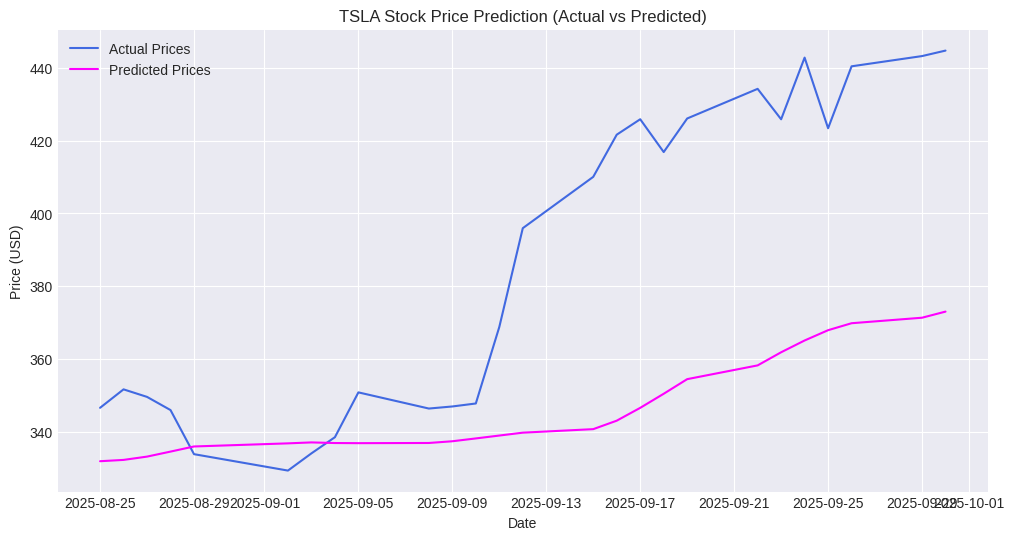


Mean Squared Error (MSE): 2562.521814390071


In [13]:
# STEP 8: Model Prediction and Visualization
# (Lecture 3 – Model Evaluation & Visualization)
# (Lecture 8 – Forecasting with Recurrent Networks)

# Predict stock prices using the trained model
predictions = model.predict(X_test)

# Convert scaled predictions back to original 'Close' prices
# Get the scaler parameters used for the 'Close' feature (first column)
close_min = scaler.data_min_[0]
close_max = scaler.data_max_[0]

# Undo scaling manually for Close price
predictions_unscaled = predictions * (close_max - close_min) + close_min
y_test_actual_unscaled = y_test * (close_max - close_min) + close_min

# Attach Dates to Predictions (for readability)
pred_dates = data.index[-len(y_test_actual_unscaled):]

# Create DataFrame for inspection
result_df = pd.DataFrame({
    'Date': pred_dates,
    'Actual Price': y_test_actual_unscaled.flatten(),
    'Predicted Price': predictions_unscaled.flatten()
})

print("\nSample of Actual vs Predicted Prices with Dates:\n")
print(result_df.tail(10))

# Plot actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(result_df['Date'], result_df['Actual Price'], label="Actual Prices", color='royalblue')
plt.plot(result_df['Date'], result_df['Predicted Price'], label="Predicted Prices", color='magenta')
plt.title(f"{ticker} Stock Price Prediction (Actual vs Predicted)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Calculate and print Mean Squared Error using unscaled values
mse = mean_squared_error(y_test_actual_unscaled, predictions_unscaled)
print("\nMean Squared Error (MSE):", mse)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


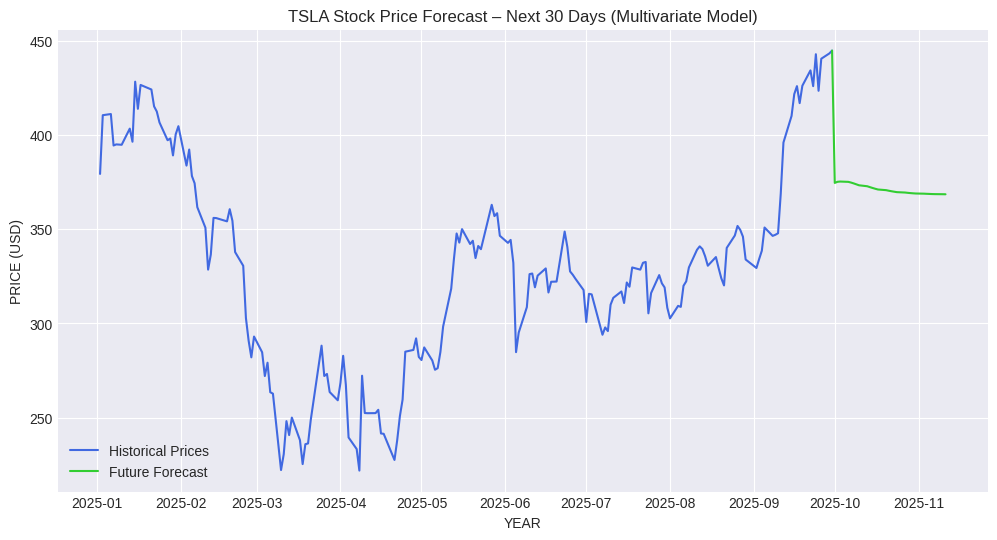

In [14]:
# STEP 10 (Multivariate): Future Forecasting Beyond the Dataset
# (Lecture 8 – Forecasting using RNN sequence memory)

future_days = 30  # For longer forecast

# Take the last 30 days of all 9 features (correcting from 8)
last_30_days = scaled_multi[-30:, :]
future_input = last_30_days.reshape(1, 30, last_30_days.shape[1]).copy() # Use shape[1] to dynamically get the number of features

future_predictions = []

for _ in range(future_days):
    # Predict only the next day's 'Close' (first feature)
    next_close_scaled = model.predict(future_input)[0][0]
    future_predictions.append(next_close_scaled)

    # Create the next input window:
    # start with previous sequence, drop first row
    next_sequence = future_input[:, 1:, :].copy()

    # For the new day:
    # keep other feature values same as last day
    new_day = future_input[:, -1, :].copy()
    new_day[0][0] = next_close_scaled  # replace Close value with predicted one

    # Append new day to the end
    next_sequence = np.append(next_sequence, new_day.reshape(1, 1, last_30_days.shape[1]), axis=1) # Use shape[1]
    future_input = next_sequence

# Convert only the Close predictions back to original scale
close_min = scaler.data_min_[0]
close_max = scaler.data_max_[0]
future_predictions_unscaled = np.array(future_predictions) * (close_max - close_min) + close_min

# Create future business-day dates
last_date = data.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1),
                             periods=future_days, freq='B')

# Combine into a DataFrame
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price': future_predictions_unscaled.flatten()
})

print("\nPredicted Future Prices:\n")
print(future_df)

# To make sure there is no gap between historical and forecast lines
last_actual_price = data['Close'].iloc[-1]
last_actual_date = data.index[-1]

# Insert the last known point at the start of the future forecast
future_df = pd.concat([
    pd.DataFrame({'Date': [last_actual_date], 'Predicted Price': [last_actual_price]}),
    future_df
], ignore_index=True)


# Plot historical + future forecast
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label="Historical Prices", color='royalblue')
plt.plot(future_df['Date'], future_df['Predicted Price'],
         label="Future Forecast", color='limegreen')
plt.title(f"{ticker} Stock Price Forecast – Next {future_days} Days (Multivariate Model)")
plt.xlabel("YEAR")
plt.ylabel("PRICE (USD)")
plt.legend()
plt.show()

/tmp/ipython-input-577724428.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  start_price = float(future_df['Predicted Price'].iloc[0])
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)



--- Investment Advice ---
Predicted change over next 31 days: -17.14%

Model Suggests: 
 DOWNTREND DETECTED – Avoid investing right now or consider SELLING. 

R² Score: -0.4199638818725815

Report generated on: 2025-11-14 10:00 AM 



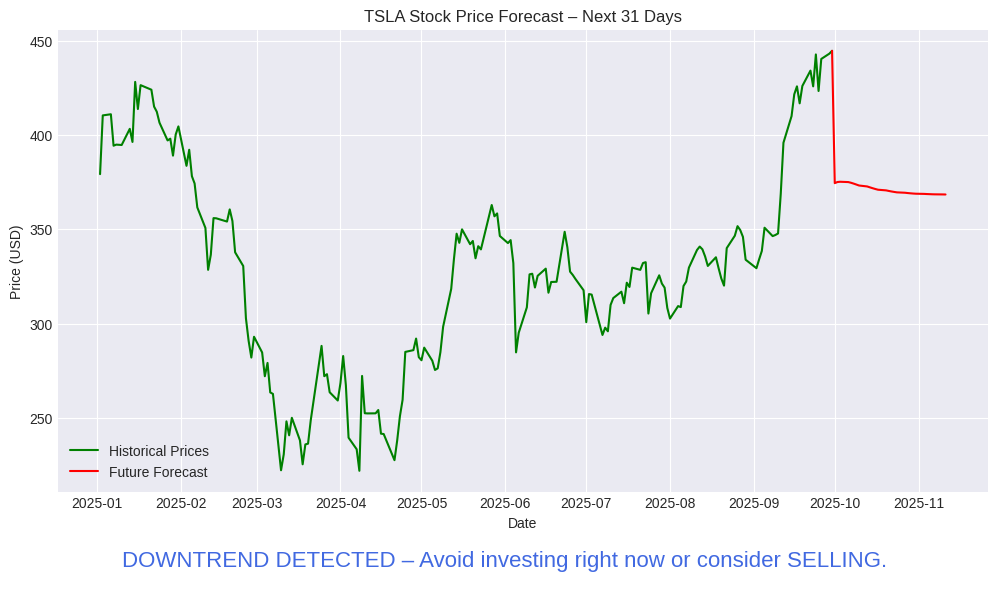

<Figure size 640x480 with 0 Axes>

In [15]:
# STEP 11: Investment Advice Based on Predicted Trend
# (Lecture 3 – Model Evaluation & Decision Making)

# Working with scalar (not Series) values
start_price = float(future_df['Predicted Price'].iloc[0])
end_price = float(future_df['Predicted Price'].iloc[-1])

# Calculate percent change between first and last predicted price
percent_change = ((end_price - start_price) / start_price) * 100

# Decide recommendation (right time to invest in it or not)
if percent_change > 2:
    advice = "STRONG UPTREND DETECTED !! – It may be a good time to INVEST (BUY). \n"
elif percent_change < -2:
    advice = "DOWNTREND DETECTED – Avoid investing right now or consider SELLING. \n"
else:
    advice = "Stable trend – Market appears steady. Consider HOLDING your position. \n"

print("\n--- Investment Advice ---")
print(f"Predicted change over next {len(future_df)} days: {percent_change:.2f}%")
print()
print("Model Suggests: \n", advice)


r2 = r2_score(y_test_actual_unscaled, predictions_unscaled)
print("R² Score:", r2)

# Plot
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label="Historical Prices", color='green')

print()

# Set timezone to Toronto (Eastern Time)
toronto_tz = pytz.timezone('America/Toronto')

# Get current local time in Toronto
local_time = datetime.datetime.now(toronto_tz)

print("Report generated on:", local_time.strftime("%Y-%m-%d %I:%M %p \n"))

plt.plot(future_df['Date'], future_df['Predicted Price'], label="Future Forecast", color='red')
plt.title(f"{ticker} Stock Price Forecast – Next {len(future_df)} Days")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.figtext(0.5, -0.05, advice, wrap=True, ha='center', fontsize=16, color='royalblue')
plt.show()
plt.savefig("MSFT_Forecast_Results.png", dpi=300, bbox_inches='tight') # to save the final figure

In [16]:
# STEP 12: Model Performance Summary
# 12.1 Accuracy of the model: show how closely predicted prices match real prices.

# Calculate metrics
mse = mean_squared_error(y_test_actual_unscaled, predictions_unscaled)
mae = mean_absolute_error(y_test_actual_unscaled, predictions_unscaled)
r2 = r2_score(y_test_actual_unscaled, predictions_unscaled)

# Display results neatly
print("\n        MODEL PERFORMANCE SUMMARY \n")
print(f"Mean Squared Error (MSE):      {mse:.6f}")
print(f"Mean Absolute Error (MAE):     {mae:.4f} USD")
print(f"R² Score (Model Fit):          {r2:.4f}")
print()

# 12.2 single RNN Model trained using LSTM layers

total_layers = len(model.layers)
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
print(f"Number of layers in this single model: {total_layers}")
print(f"Total trainable parameters: {trainable_params:,}")
print()

# Brief interpretation for output readability
if r2 > 0.9:
    print("✅ Excellent model fit! Predictions closely follow actual prices.")
elif r2 > 0.75:
    print("✅ Good model fit. Model captures major trends well.")
else:
    print("⚠️ Model could be improved with more epochs, features, or tuning.")



        MODEL PERFORMANCE SUMMARY 

Mean Squared Error (MSE):      2562.521814
Mean Absolute Error (MAE):     40.6520 USD
R² Score (Model Fit):          -0.4200

Number of layers in this single model: 6
Total trainable parameters: 54,081

⚠️ Model could be improved with more epochs, features, or tuning.
